In [121]:
#%matplotlib notebook
#%matplotlib widget
%matplotlib inline

import (
    math
    , numba
    , pprint
    , pylab
)

import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets

from itertools import islice

from ipywidgets import (
    interact
    , interact_manual
    , fixed
    , FloatSlider
    , Dropdown
)

pylab.rcParams['figure.figsize'] = (14.0, 8.0)
plt.style.use('dark_background')

In [60]:
def tg_pprint(*args, **kwargs):
    return pprint.pprint(*args, **kwargs, width=200)

In [61]:
@numba.jit
def log_map_gen(x0=.5, r=2.4):
    xn1=x0
    yield xn1
    while True:
        xn=xn1
        xn1 = r*xn*(1.-xn)
        yield xn1

In [62]:
def n_log_map(x0=.5, r=2.4, n=10, astuple=True):
    g=islice(log_map_gen(x0=x0, r=r), n)
    if astuple: return tuple(g)
    else:       return       g

In [63]:
@numba.jit
def nth_log_map(x0=.5, r=2.4, n=10):
    for i, xn1 in enumerate(log_map_gen(x0=x0, r=r)):
        if i >= n or math.isinf(xn1):
            return xn1, i

In [64]:
@numba.jit
def nth_log_map_eps(x0=.5, r=2.4, n=10, eps=1e-10):
    xn=-2
    for i, xn1 in enumerate(log_map_gen(x0=x0, r=r)):
        diff = math.fabs(xn1 - xn)
        xn   = xn1
        if diff < eps or i >= n or math.isinf(xn):
            return xn1, i

In [66]:
@numba.jit
def gen_rs(rmin=1., rmax=4., nbins=2000):
    delta = rmax - rmin
    for i in range(nbins):
        yield rmin + delta * i / nbins

In [67]:
@numba.jit
def gen_r_e(rmin=1., rmax=4., nbins=2000, x0=.5, niter=500, eps=1e-12):
    for r in gen_rs(rmin, rmax, nbins):
        xn, i = nth_log_map_eps(x0=x0, r=r, n=niter, eps=eps)
        yield r, xn

In [73]:
def foo(nbins=2000, x0=.5, niter=500, eps=1e-10):
    for r in gen_rs(nbins=nbins):
        xn   = nth_log_map(    x0=.5, r=r, n=niter)
        xne  = nth_log_map_eps(x0=.5, r=r, n=niter, eps=1e-10)
        diff = math.fabs(xne[0] - xn[0])
        assert diff < 25*eps, f'xne: {xne[0]} xn: {xn[0]} diff: {diff}'
        tg_pprint((r, xn, xne, xne[0]-xn[0]))

In [74]:
#import bokeh.plotting as plotting

#plotting.output_notebook()

#f = plotting.figure(plot_width=600, plot_height=400)
#f.circle(*zip(*gen_r_e(nbins=500000)),size=.5)
#plotting.show(f)

In [120]:
@interact_manual(
     rmin_=(0, 4.0, 0.0001)
    ,rmax_=(0, 4.0, 0.0001)
)
def foobar(rmin_=0, rmax_=4.0):
    @interact_manual(
                         #rmin=FloatSlider(3.5, min=2.6, max=4., step=0.0001)
                        #,rmax=FloatSlider(3.7, min=2.6, max=4., step=0.0001)
                         rmin=FloatSlider(rmin_, min=rmin_, max=rmax_, step=0.0001)
                        ,rmax=FloatSlider(rmax_, min=rmin_, max=rmax_, step=0.0001)
                        ,min_iter=fixed(10)
                        ,max_iter=fixed(50)
                    )
    def plot_bifurication_map(rmin=0, rmax=4, min_iter=50, max_iter=100):
        #plt.yscale('linear')
        #plt.scatter(*zip(*gen_r_e(rmin=3.56, nbins=40000000)), marker='.', s=.0001)
        #plt.scatter(*zip(*gen_r_e(rmin=3.65, rmax=3.7, nbins=10000000)), marker='.', s=.0001)
        #plt.plot(*zip(*gen_r_e(rmin=3.65, rmax=3.7, nbins=100000)), marker='.', linewidth=0, markersize=.2)
        for r in gen_rs(rmin=rmin, rmax=rmax):
            xs = tuple(islice(log_map_gen(r=r), min_iter, max_iter))
            plt.plot(len(xs)*(r,), xs, marker='.', linewidth=0, markersize=.2)

interactive(children=(FloatSlider(value=0.0, description='rmin_', max=4.0, step=0.0001), FloatSlider(value=4.0…

In [111]:
@interact(
            x0=FloatSlider(.5, min=0., max=1., step=.001)
            ,r=FloatSlider(2.98, min=0., max=4., step=.001)
#            ,n=fixed(200)
#            ,n=[('30', 30), ('100', 100), ('200', 200)]
            ,n=Dropdown(options=[30, 100, 200])
         )
def graph_pop(x0=.5, r=2.4, n=30):
    ts = range(n)
    xs = tuple(islice(log_map_gen(x0=x0, r=r), n))
    #tg_pprint(xs)
    plt.ylim((0, 1.))
    plt.plot(ts, xs, marker=',')

interactive(children=(FloatSlider(value=0.5, description='x0', max=1.0, step=0.001), FloatSlider(value=2.98, d…

In [130]:
def gen_mandel(xrng=(-2,.5), yrng=(-1,1), horizon=2, nbins=100, niter=32):
    rng = ((xrng[1] - xrng[0])
          ,(yrng[1] - yrng[0])
          )
    delta = tuple(map(lambda v: v/nbins, rng))

    xs = np.linspace(*xrng, nbins, dtype=float)
    ys = np.linspace(*yrng, nbins, dtype=float)
    cs = xs + ys[:, None]*1j
    ns = np.zeros(cs.shape, dtype=int)
    zs = np.zeros(cs.shape, dtype=np.complex64)
    m  = np.zeros((nbins, nbins), dtype=complex)
    
    for it in range(niter):
        i = np.less(abs(zs), horizon)
        ns[i] = it
        zs[i] = zs[i]**2 + cs[i]
    ns[ns == niter - 1] = 0
    
    log_horizon = np.log(np.log(horizon))/np.log(2)
    with np.errstate(invalid='ignore'):
        zs = np.nan_to_num(ns + 1 - np.log(np.log(abs(zs))/np.log(2) + log_horizon))
    return zs, ns, cs

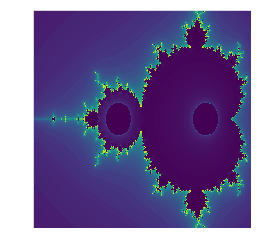

In [171]:
zs, ns, cs = gen_mandel(nbins=1000, horizon=2**10)
#plt.countour(xs, ys, np.absolute(m))
plt.imshow(np.absolute(zs))
#tg_pprint(zs)

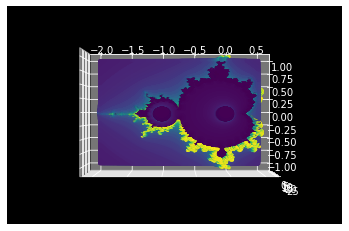

In [159]:
from mpl_toolkits import mplot3d

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.view_init(azim=-90, elev=90)
ax.scatter3D(cs.real, cs.imag, abs(zs), c=abs(zs).flat, marker='.')

In [156]:
abs(2+-1.324j)

2.398536220281028

In [184]:
print(np.finfo(np.float64))

Machine parameters for float64
---------------------------------------------------------------
precision =  15   resolution = 1.0000000000000001e-15
machep =    -52   eps =        2.2204460492503131e-16
negep =     -53   epsneg =     1.1102230246251565e-16
minexp =  -1022   tiny =       2.2250738585072014e-308
maxexp =   1024   max =        1.7976931348623157e+308
nexp =       11   min =        -max
---------------------------------------------------------------



In [13]:
import ipywidgets as widgets